# Optimisation on Logistic Regression using Grid Search

In this repo, we use the HEBO package to perform Bayesian Optimisation Hyperparameter search. We will use this to try to find the optimal hyper-parameters for a Logistic Regression model to classify returns on Gold daily prices.

### Import Packages

In [120]:
import sys

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from hebo.optimizers.bo import BO
from hebo.design_space.design_space import DesignSpace

# Data

For this notebook, we will work with daily gold price historical data available on Kaggle: 

https://www.kaggle.com/datasets/psycon/daily-gold-price-historical-data

The objective is to determine the next-day's forward return sign by training a model on past data. This is a straightforward supervised machine learning classification tast: given past data, we want to train a binary outcome on test data.

In [30]:
# read in raw data
df = pd.read_csv('data/gold.csv')
df.head()

,Date,Open,High,Low,Close,Volume,Currency
0,2000-01-04,289.5,289.5,280.0,283.7,21621,USD
1,2000-01-05,283.7,285.0,281.0,282.1,25448,USD
2,2000-01-06,281.6,282.8,280.2,282.4,19055,USD
3,2000-01-07,282.5,284.5,282.0,282.9,11266,USD
4,2000-01-10,282.4,283.9,281.8,282.7,30603,USD


In [31]:
# prep dataframe
df = df.set_index('Date').drop(columns='Currency')
df.index = pd.to_datetime(df.index)
df.columns = [x.lower() for x in df.columns]

In [32]:
# look at dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5703 entries, 2000-01-04 to 2022-09-02
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    5703 non-null   float64
 1   high    5703 non-null   float64
 2   low     5703 non-null   float64
 3   close   5703 non-null   float64
 4   volume  5703 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 267.3 KB


In [33]:
# check for zeros, or outliers
num = 0
for i in df.columns:
    zero_count = df[i][df[i]==0].count()
    print(f'Total zeros in {i} column: {zero_count}')

Total zeros in open column: 0
Total zeros in high column: 0
Total zeros in low column: 0
Total zeros in close column: 0
Total zeros in volume column: 10


In [35]:
# drop zero volume rows
df = df[df.volume!=0]

### Convert non-stationary prices into stationary returns

In [74]:
# create X, y partitions
X = (np.log(df/df.shift(1))).dropna()
y = np.sign(np.log(df.close.shift(-1)/df.close).dropna())
y.name = 'y'

# remove zero ys
y = y[y!=0]

# join X,y
train_df = pd.concat((X, y), axis=1, join='inner')
# re-split
y = train_df.y
X = train_df.drop(columns='y')

### Distribution of Label

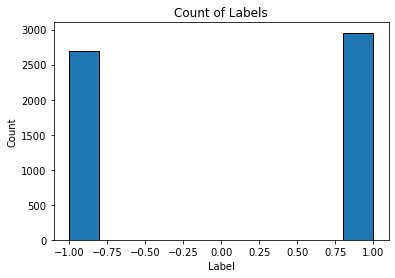

In [75]:
plt.hist(y, edgecolor='k');
plt.xlabel('Label'); plt.ylabel('Count'); plt.title('Count of Labels');

There is a small class imbalance here that will be accounted for when using the Logistic Regression model.

### Separate into training and testing sets 

In [86]:
# assumptions: 70% training, 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

### Scale X training and test set

In [87]:
# create scaling model
sca_model = StandardScaler()

In [88]:
# fit model to training data
sca_model.fit(X_train);

In [89]:
# transform the raw data
X_train = sca_model.transform(X_train)
X_test = sca_model.transform(X_test)

# Logistic Regression Model

We will use the SciKit-Learn implementation of the Logistic Regression model. Due to the small imbalance in our classes, we shall ensure our class weights are set to balanced.

In [100]:
# set model
model = LogisticRegression(fit_intercept=True, class_weight='balanced', random_state=42)

We shall set a wide range of parameters for the grid search

In [101]:
# set hyper parameters
parameters = [{'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']},
              {'penalty': ['none', 'elasticnet', 'l1', 'l2']},
              {'C': [0.001, 0.01, 0.1, 1, 10, 100]}]

We shall implement SciKit-Learn's out of the box GridSearchCV implementation that also incorporates cross-validation within training with accuracy as our metric

In [112]:
# set grid search
grid_search = GridSearchCV(estimator=model, param_grid=parameters, scoring='accuracy', cv=3, verbose=2)

All we need to do is to fit the model on the training data and make predictions on the testing data.

In [113]:
# fit model
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV] END ...................................solver=newton-cg; total time=   0.0s
[CV] END ...................................solver=newton-cg; total time=   0.0s
[CV] END ...................................solver=newton-cg; total time=   0.0s
[CV] END .......................................solver=lbfgs; total time=   0.0s
[CV] END .......................................solver=lbfgs; total time=   0.0s
[CV] END .......................................solver=lbfgs; total time=   0.0s
[CV] END ...................................solver=liblinear; total time=   0.0s
[CV] END ...................................solver=liblinear; total time=   0.0s
[CV] END ...................................solver=liblinear; total time=   0.0s
[CV] END .........................................solver=sag; total time=   0.0s
[CV] END .........................................solver=sag; total time=   0.0s
[CV] END .......................................

GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=42),
             param_grid=[{'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                     'saga']},
                         {'penalty': ['none', 'elasticnet', 'l1', 'l2']},
                         {'C': [0.001, 0.01, 0.1, 1, 10, 100]}],
             scoring='accuracy', verbose=2)

In [125]:
test_predictions = grid_search.predict(X_test)
out_sample_accuracy = accuracy_score(y_test, test_predictions)

print("tuned hyperparameters :(best parameters) ",grid_search.best_params_)
print("in-sample accuracy :",grid_search.best_score_)
print("out-of-sample accuracy :", out_sample_accuracy)

tuned hyperparameters :(best parameters)  {'C': 0.01}
in-sample accuracy : 0.5293694643886084
out-of-sample accuracy : 0.5200708382526564


The results are encouraging for financial data but given the small size of the dataset, in order to improve performance, it probably makes sense to gather more data and create additional features